## Directory

In [27]:
import os

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
os.chdir("/content/drive/MyDrive/vapaad gifs")

## Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Acquire Data

In [3]:
%%time

# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

819200096/819200096 [==============================] - 29s 0us/step
Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
CPU times: user 2.9 s, sys: 3.93 s, total: 6.82 s
Wall time: 30.3 s


### Visualization

Displaying frames for example 825.


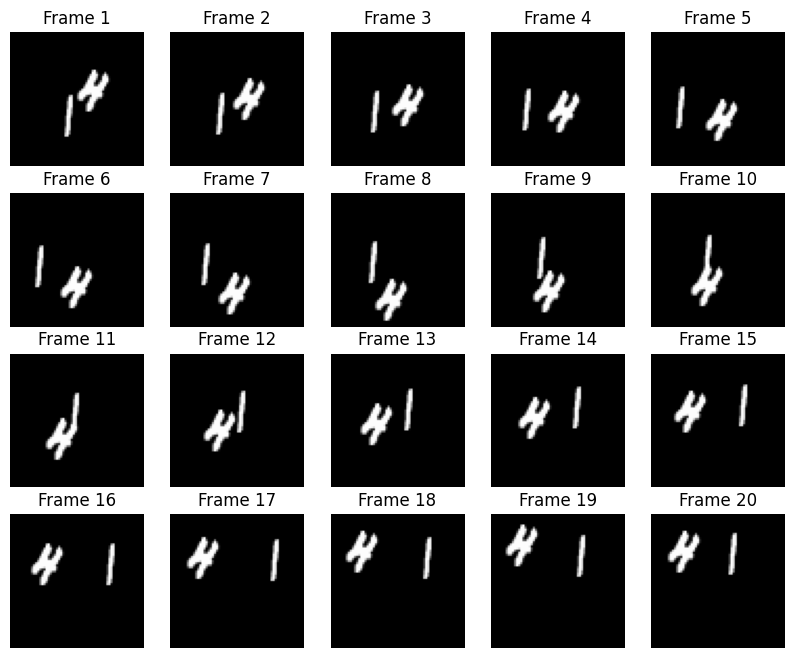

CPU times: user 1.23 s, sys: 251 ms, total: 1.48 s
Wall time: 1.25 s


In [ ]:
%%time

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_image_sequences(x_train, y_train, num_samples=5):
    """
    Plots sequences of input and output images for a number of samples, with titles.

    Args:
    x_train (np.ndarray): Input image sequences.
    y_train (np.ndarray): Output image sequences.
    num_samples (int): Number of samples to plot.
    """
    fig, axes = plt.subplots(num_samples, 38, figsize=(38, num_samples * 2))  # Adjusted figsize for title space
    fig.suptitle("Sample Input/Output Sequence Images from Moving MNIST", fontsize=25, y=1.05)
    plt.figtext(0.5, 1.01, "First 19 frames are input sequences whereas latter 19 frames are output sequences",
                ha='center', fontsize=25, va='top')

    for i in range(num_samples):
        for j in range(19):  # Plot input images
            axes[i, j].imshow(x_train[i, j, :, :, 0], cmap='gray')
            axes[i, j].set_title(f'Frame {j + 1}', fontsize=8)
            axes[i, j].axis('off')
        for j in range(19):  # Plot output images
            axes[i, j + 19].imshow(y_train[i, j, :, :, 0], cmap='gray')
            axes[i, j + 19].set_title(f'Frame {j + 20}', fontsize=8)
            axes[i, j + 19].axis('off')

    plt.tight_layout()
    plt.show()

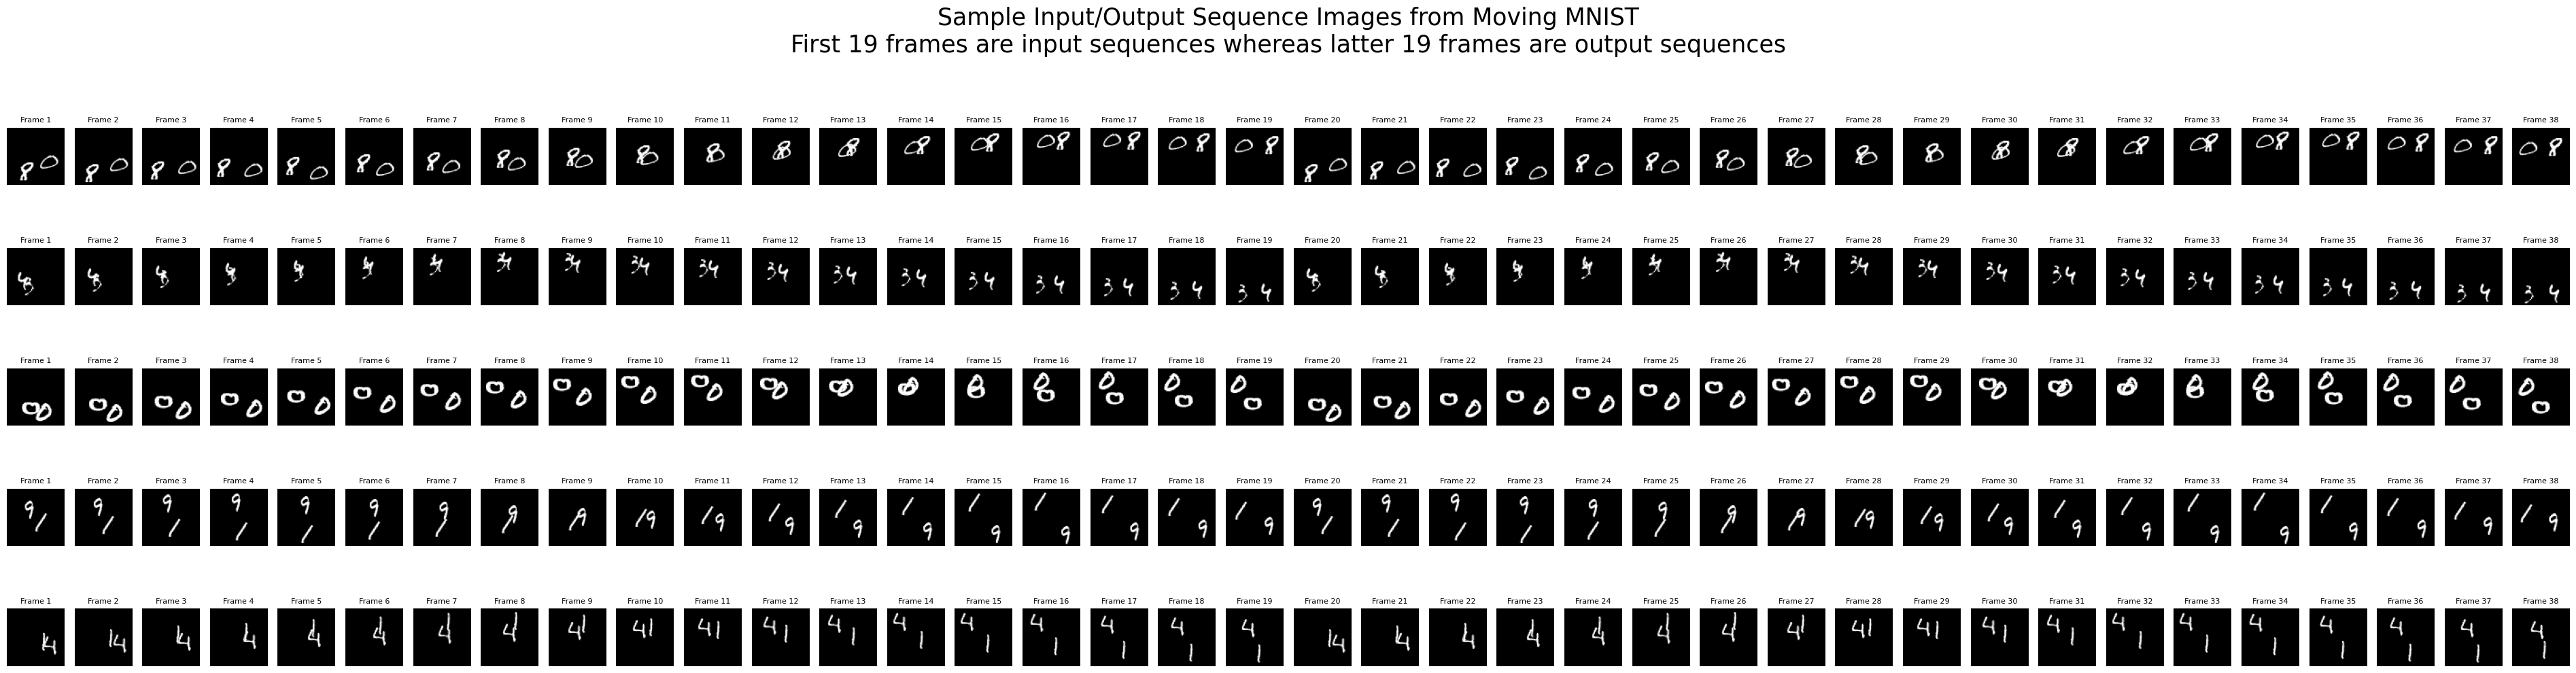

CPU times: user 12.2 s, sys: 403 ms, total: 12.6 s
Wall time: 12.2 s


In [ ]:
%%time

# Example usage
plot_image_sequences(x_train, y_train)

## Build `VAPAAD` Model

In [21]:
import time
from datetime import datetime
from typing import Tuple

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class SelfAttention(layers.Layer):
    """
    A custom self-attention layer that computes attention scores to enhance model performance by focusing on relevant parts of the input data.

    This layer creates query, key, and value representations of the input, then calculates attention scores to determine how much focus to put on each part of the input data. The output is a combination of the input and the attention mechanism's weighted focus, which allows the model to pay more attention to certain parts of the data.

    Attributes:
        query_dense (keras.layers.Dense): A dense layer for transforming the input into a query tensor.
        key_dense (keras.layers.Dense): A dense layer for transforming the input into a key tensor.
        value_dense (keras.layers.Dense): A dense layer for transforming the input into a value tensor.
        combine_heads (keras.layers.Dense): A dense layer for combining the attention heads' outputs.
    """

    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape: Tuple[int, ...]):
        """
        Initializes the internal dense layers based on the last dimension of the input shape, setting up the query, key, value, and combine heads layers.

        Args:
            input_shape (Tuple[int, ...]): The shape of the input tensor to the layer.
        """
        self.query_dense = layers.Dense(units=input_shape[-1])
        self.key_dense = layers.Dense(units=input_shape[-1])
        self.value_dense = layers.Dense(units=input_shape[-1])
        self.combine_heads = layers.Dense(units=input_shape[-1])

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Performs the self-attention mechanism on the input tensor and returns the combined output with a residual connection.

        Args:
            inputs (tf.Tensor): The input tensor to the self-attention layer.

        Returns:
            tf.Tensor: The output tensor after applying self-attention and combining with the input tensor through a residual connection.
        """
        # Generate query, key, value tensors
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Calculate attention scores
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores)
        attention_output = tf.matmul(distribution, value)

        # Combine heads and add residual connection
        combined_output = self.combine_heads(attention_output) + inputs
        return combined_output


class VAPAAD:
    """A class to handle video processing with data augmentation and self-attention mechanisms."""

    def __init__(self, input_shape: Tuple[int, int, int]):
        self.input_shape = input_shape
        # Initialize generator and instructor models
        self.gen_main = self.build_generator()
        self.gen_aux = self.build_generator()
        self.instructor = self.build_instructor()
        # Define loss functions and optimizers
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.instructor_optimizer = tf.keras.optimizers.Adam(1e-4)

    def build_generator(self) -> keras.Model:
        """
        Constructs the generator model for video processing with data augmentation and self-attention.

        This method is responsible for creating a generator model that performs augmentations on input
        frames and then processes them through ConvLSTM2D layers with self-attention, finally applying a
        convolution across the time dimension to generate output frames.

        The model is part of a generative approach and could be used in tasks such as video frame prediction,
        unsupervised learning, or as a part of a Generative Adversarial Network (GAN).

        Returns:
            A Keras model that takes a sequence of frames as input, augments them via random zooming, rotations,
            and translations, and then outputs processed frames with the same sequence length as the input.

        Note: 'input_shape' should be an attribute of the class instance, and 'SelfAttention' is expected
        to be either a predefined layer in Keras or a custom implementation provided in the code.

        Example usage:
            generator = build_generator()
        """
        # Data augmentation layers intended to increase robustness and generalization
        data_augmentation = keras.Sequential(
            [
                layers.RandomZoom(height_factor=0.05, width_factor=0.05),
                layers.RandomRotation(factor=0.02),
                layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
            ],
            name="data_augmentation",
        )

        # Input layer defining the shape of the input frames
        inp = layers.Input(shape=self.input_shape)
        # Apply time distributed data augmentation which applies the augmentation to each frame independently
        x = layers.TimeDistributed(data_augmentation)(inp)
        # Convolutional LSTM layer with relu activation to capture temporal features
        x = layers.ConvLSTM2D(
            filters=64,
            kernel_size=(5, 5),
            padding="same",
            return_sequences=True,
            activation="relu",
        )(x)
        # Batch normalization to help maintain the stability of the network
        x = layers.BatchNormalization()(x)
        # Self-attention layer for capturing long-range dependencies within the sequences
        x = SelfAttention()(x)
        # Conv3D layer to process the features obtained from previous layers and produce a sequence of frames
        x = layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        )(x)

        # Construct the model with the specified input and output tensors
        return keras.models.Model(inputs=inp, outputs=x)

    def build_instructor(self) -> keras.Model:
        """
        Constructs the instructor model with convolutional LSTM and fully connected layers.

        This method specifically builds a video processing instructor model that uses ConvLSTM2D layers,
        followed by self-attention, global average pooling, and dense layers to process the input frames
        and predict a one-dimensional output.

        The architecture is designed for sequential data processing ideal for video or time-series data.

        Returns:
            A compiled Keras model that takes a sequence of frames as input and outputs a
            one-dimensional tensor after processing through ConvLSTM2D, self-attention,
            and dense layers. The output can be interpreted as the probability of a certain
            class or a value depending on the final activation function used (sigmoid in this case).

        Note: 'input_shape' should be an attribute of the class instance, and 'SelfAttention' is
        assumed to be a pre-defined layer or a custom layer implemented elsewhere in the code.

        Example usage:
            model = build_instructor()
        """
        # Input layer defining the shape of the input frames
        inp = layers.Input(shape=self.input_shape)
        # Convolutional LSTM layer with relu activation
        x = layers.ConvLSTM2D(
            filters=64,
            kernel_size=(3, 3),
            padding="same",
            return_sequences=True,
            activation="relu",
        )(inp)
        # Batch Normalization layer
        x = layers.BatchNormalization()(x)
        # Self-attention layer for sequence learning
        x = SelfAttention()(x)
        # Global Average Pooling across the frames to get a feature vector
        x = layers.GlobalAveragePooling3D()(x)
        # Fully connected layers with relu activation
        x = layers.Dense(1024, activation="relu")(x)
        x = layers.Dense(512, activation="relu")(x)
        # Output layer with sigmoid activation for binary classification or regression tasks
        output = layers.Dense(1, activation="sigmoid")(x)

        # Construct the model with specified layers
        return keras.models.Model(inputs=inp, outputs=output)

    def train_step(
        self, images: tf.Tensor, future_images: tf.Tensor
    ) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Perform a single training step by updating the generator and instructor models.

        This method applies gradient descent to both the generator and the instructor models
        based on the loss computed from the real and generated images.

        Args:
            images (tf.Tensor): A tensor of input images for the current time step provided
                                to the generator model 'gen_main'.
            future_images (tf.Tensor): A tensor of target images for the future time step provided
                                    to the generator model 'gen_aux'.

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: A tuple containing the loss values for the generator model
                                        ('gen_loss') and the instructor model ('inst_loss').

        Note: 'gen_optimizer' and 'inst_optimizer' should be attributes of the class instance.

        The function uses TensorFlow operations and assumes that 'gen_main', 'gen_aux', 'instructor',
        'generator_optimizer', 'instructor_optimizer', 'generator_loss', and 'instructor_loss' are
        defined as attributes of the class in which this method is implemented.
        """
        with tf.GradientTape() as gen_tape, tf.GradientTape() as inst_tape:
            # Generate outputs for both current and future inputs
            output_main = self.gen_main(images, training=True)
            output_aux = self.gen_aux(future_images, training=True)
            real_output = self.instructor(output_aux, training=True)
            fake_output = self.instructor(output_main, training=True)

            # Calculate losses for both models
            gen_loss = self.generator_loss(fake_output)
            inst_loss = self.instructor_loss(real_output, fake_output)

        # Apply gradients to update model weights
        gradients_of_gen = gen_tape.gradient(
            gen_loss, self.gen_main.trainable_variables
        )
        gradients_of_inst = inst_tape.gradient(
            inst_loss, self.instructor.trainable_variables
        )
        self.generator_optimizer.apply_gradients(
            zip(gradients_of_gen, self.gen_main.trainable_variables)
        )
        self.instructor_optimizer.apply_gradients(
            zip(gradients_of_inst, self.instructor.trainable_variables)
        )

        return gen_loss, inst_loss

    def generator_loss(self, fake_output):
        """
        Calculates the loss for the generator model based on its output for generated (fake) images.

        The loss encourages the generator to produce images that the instructor model classifies as real.
        This is achieved by comparing the generator's output for fake images against a target tensor of ones,
        indicating that the ideal output of the generator would be classified as real by the instructor model.

        Args:
        fake_output (tf.Tensor): The generator model's output logits for generated (fake) images.

        Returns:
        tf.Tensor: The loss for the generator model, encouraging it to generate more realistic images.
        """
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def instructor_loss(self, real_output, fake_output):
        """
        Calculates the loss for the instructor model based on its output for real and generated (fake) images.

        The loss is computed as the sum of the cross-entropy losses for the real and fake outputs. For real images,
        the target is a tensor of ones, and for fake images, the target is a tensor of zeros.

        Args:
        real_output (tf.Tensor): The instructor model's output logits for real images.
        fake_output (tf.Tensor): The instructor model's output logits for generated (fake) images.

        Returns:
        tf.Tensor: The total loss for the instructor model, combining the real and fake loss components.
        """
        # Define real_loss and fake_loss
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def train(self, x_train, y_train, batch_size=64):
        """
        Trains the model for a specified batch size.

        This function iterates over the entire dataset for a epoch,
        randomly selecting batches of data to perform training steps. The selection is random
        and without replacement within each epoch, ensuring diverse exposure of data.

        Args:
        x_train (np.ndarray): The input training data.
        y_train (np.ndarray): The target training data.
        batch_size (int, optional): The number of samples per batch of computation. Defaults to 64.

        Returns:
        None
        """
        n_samples = x_train.shape[0]
        start = time.time()
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        for i in range(0, n_samples, batch_size):
            if i + batch_size > n_samples:
                continue  # Avoid index error on the last batch if it's smaller than the batch size
            selected_indices = indices[i : i + batch_size]
            x_batch = x_train[selected_indices]
            y_batch = y_train[selected_indices]
            curr_gen_loss, curr_inst_loss = self.train_step(x_batch, y_batch)
            if curr_gen_loss < 0.2:  # Early stopping condition
                print(f"Stopping early at epoch {i + 1}")
                return

            print(
                f"> running: current sample {i + 1}, gen_loss={curr_gen_loss}, inst_loss={curr_inst_loss}, time={time.time() - start} sec"
            )

    def __read_me__(self):
        """
        This function prints a multi-line formatted instruction manual for running a VAPAAD model.

        The instructions include how to inspect the data shapes of training and validation datasets,
        initializing the VAPAAD model, selecting a random subset of the training data for training,
        and finally, running the model with GPU support if available.

        There are no parameters for this function and it doesn't return anything.
        It simply prints the instructional text to the console when called.
        """
        now = datetime.now()
        current_year = now.year
        print(
            f"""
            ## Instructions

            Assume you have data as the follows:

            ```py
            # Inspect the dataset.
            print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
            print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

            # output
            # Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
            # Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
            ```

            To run the model, execute the following:
            ```py
            # Initializing a new VAPAAD model
            vapaad_model = VAPAAD(input_shape=(19, 64, 64, 1))

            # Assuming x_train and y_train are already defined and loaded
            num_samples = 64
            indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
            print(indices[0:6])
            x_train_sub = x_train[indices]
            y_train_sub = y_train[indices]
            print(x_train_sub.shape, y_train_sub.shape)

            # Example usage:
            BATCH_SIZE = 3
            if tf.test.gpu_device_name() != '':
                with tf.device('/device:GPU:0'):
                    vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
            else:
                vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
            ```

            Copyright © 2010-{current_year} Present Yiqiao Yin
            """
        )


## Get Ready for Training

In [5]:
# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


### Convert to `16bit` data

In [6]:
# Convert the data to a smaller data type to reduce memory usage
x_train = x_train.astype(np.float16)
y_train = y_train.astype(np.float16)

In [7]:
# Check gpu
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
# Assuming x_train and y_train are already defined and loaded
num_samples = 64
indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
print(indices[0:6])
x_train_sub = x_train[indices]
y_train_sub = y_train[indices]
print(x_train_sub.shape, y_train_sub.shape)

[251 340  90   0 552  16]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


## Define model: `VAPAAD`

In [37]:
# Initializing a new VAPAAD model
vapaad_model = VAPAAD(input_shape=(19, 64, 64, 1))

In [38]:
# readme
vapaad_model.__read_me__()


            ## Instructions

            Assume you have data as the follows:

            ```py
            # Inspect the dataset.
            print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
            print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

            # output
            # Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
            # Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
            ```

            To run the model, execute the following:
            ```py
            # Initializing a new VAPAAD model
            vapaad_model = VAPAAD(input_shape=(19, 64, 64, 1))

            # Assuming x_train and y_train are already defined and loaded
            num_samples = 64
            indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
            print(indices[0:6])
            x_train_sub = x_train[indices]
            y_train_sub = y_t

### Train

In [39]:
%%time

# Epochs
NUM_OF_EP = 1
for iii in range(NUM_OF_EP):

    # Assuming x_train and y_train are already defined and loaded
    num_samples = 64
    indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
    print(indices[0:6])
    x_train_sub = x_train[indices]
    y_train_sub = y_train[indices]
    print(x_train_sub.shape, y_train_sub.shape)

    # Example usage:
    BATCH_SIZE = 3
    if tf.test.gpu_device_name() != '':
        with tf.device('/device:GPU:0'):
            vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
    else:
        vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)

    print("Epoch: " + str(iii+1))

[116 391 679 632 549 313]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.6933615803718567, inst_loss=1.3867266178131104, time=4.870081901550293 sec
> running: current sample 4, gen_loss=0.6928200721740723, inst_loss=1.3863193988800049, time=6.50801157951355 sec
> running: current sample 7, gen_loss=0.6933293342590332, inst_loss=1.3849574327468872, time=8.077430009841919 sec
> running: current sample 10, gen_loss=0.6935064792633057, inst_loss=1.3860174417495728, time=9.633215427398682 sec
> running: current sample 13, gen_loss=0.6912119388580322, inst_loss=1.3840038776397705, time=11.182155132293701 sec
> running: current sample 16, gen_loss=0.6883825659751892, inst_loss=1.3823249340057373, time=12.719197750091553 sec
> running: current sample 19, gen_loss=0.6871034502983093, inst_loss=1.387155532836914, time=14.317301273345947 sec
> running: current sample 22, gen_loss=0.6827660202980042, inst_loss=1.3887231349945068, time=15.885658740997314 sec
> runni

### Extract generator

In [41]:
# Assuming you have a method to get the trained generator
trained_generator = vapaad_model.gen_main

### Prediction Using Generator

In [47]:
%%time

# prediction on validation set
if tf.test.gpu_device_name() != '':
    with tf.device('/device:GPU:0'):
        y_val_pred = trained_generator.predict(x_val)
else:
    y_val_pred = trained_generator.predict(x_val)

print("Shape of true y_val:", y_val.shape)
print("Shape of predicted y_val:", y_val_pred.shape)

4/4 [==============================] - 4s 523ms/step
Shape of true y_val: (100, 19, 64, 64, 1)
Shape of predicted y_val: (100, 19, 64, 64, 1)
CPU times: user 2.47 s, sys: 291 ms, total: 2.76 s
Wall time: 3.88 s


## Visualization

In [25]:
import numpy as np

def rescale_and_discretize(image):
    """
    Rescales an image to the 0-1 range and discretizes the values into levels {0.1, 0.2, ..., 0.9}.

    Args:
    image (np.ndarray): The input image to be rescaled and discretized.

    Returns:
    np.ndarray: The rescaled and discretized image.
    """
    # Rescale image to 0-1 range
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val) if max_val > min_val else image

    # Discretize to nearest levels in {0.1, 0.2, ..., 0.9}
    Q = 32  # Number of levels
    discretized_image = np.round(normalized_image * Q) / (Q+1)  # Multiplies by 9, rounds, then divides by 10
    discretized_image = np.clip(discretized_image, 0.1, 0.9)  # Ensures values are within the specified levels

    return discretized_image

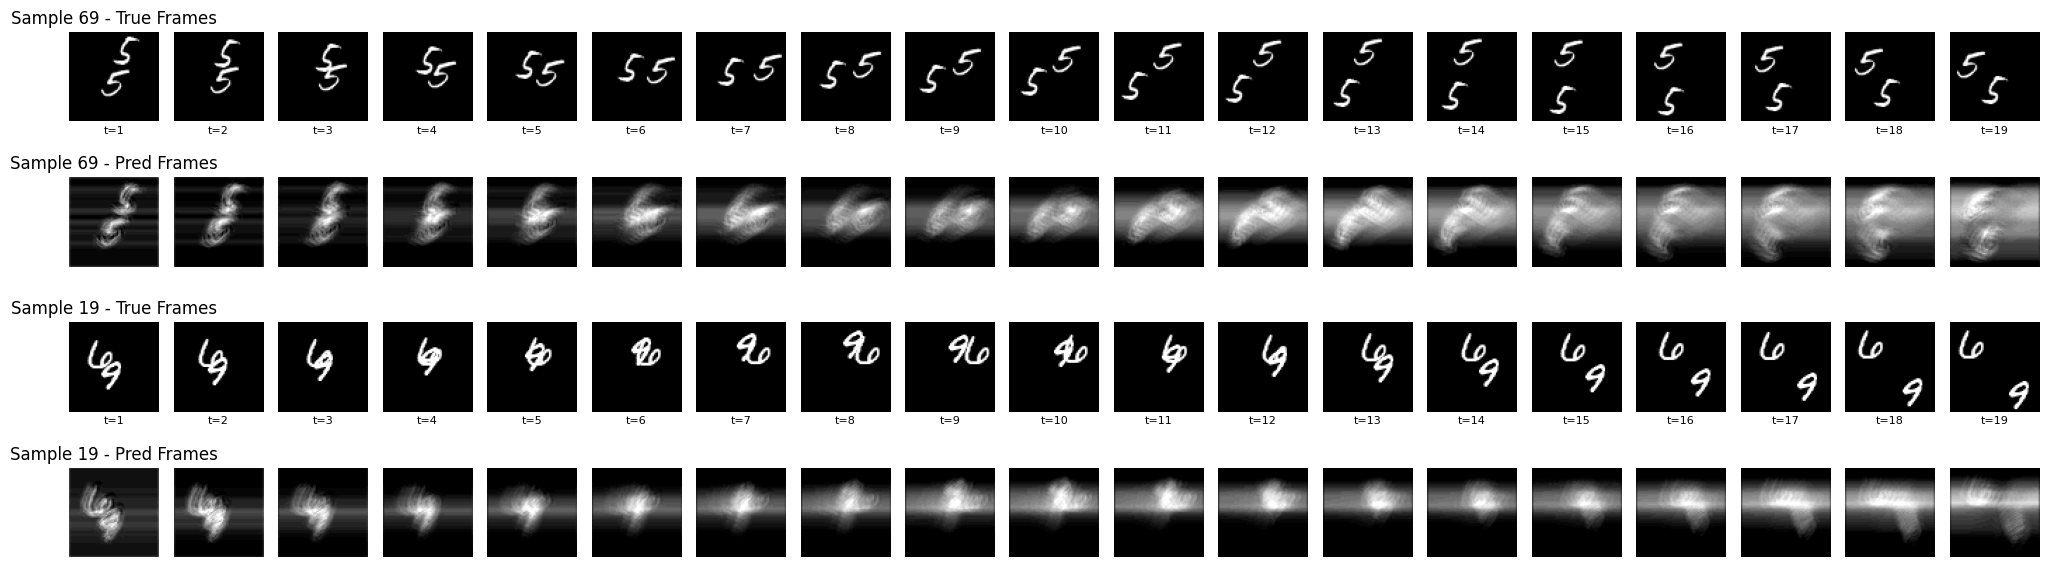

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with specified dimensions
plt.figure(figsize=(20, 6))

# Randomly select 5 samples
num_samples = 2
indices = np.random.choice(y_val.shape[0], num_samples, replace=False)

# Total number of plots per sample (19 predictions + 19 actuals)
num_plots_per_sample = 19 * 2  # 19 predicted and 19 actual

# Iterate over each of the randomly selected samples
for idx, sample_index in enumerate(indices):
    # First row for y_val (true values)
    for i in range(19):
        ax = plt.subplot(num_samples * 2, 19, 2 * idx * 19 + i + 1)  # Calculate position index
        plt.imshow(y_val[sample_index, i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - True Frames')
        plt.text(0.5, -0.1, f't={i+1}', ha='center', va='center', transform=ax.transAxes, fontsize=8)  # Adding time label

    # Second row for y_val_pred (predicted values)
    for i in range(19):
        plt.subplot(num_samples * 2, 19, (2 * idx + 1) * 19 + i + 1)  # Calculate position index
        image = y_val_pred[sample_index, i, :, :, 0]
        result_image = rescale_and_discretize(image)
        plt.imshow(result_image, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - Pred Frames')

plt.tight_layout()
plt.show()

## Create `.gif`

In [49]:
# Create a directory for the GIFs
gif_dir = "predicted_gifs_instruct_vapaad_stop_grad"
os.makedirs(gif_dir, exist_ok=True)

# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for index, example in enumerate(examples):
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the generator's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = trained_generator.predict(np.expand_dims(frames, axis=0))
        new_prediction = rescale_and_discretize(new_prediction)
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set_idx, frame_set in enumerate([original_frames, new_predictions]):
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Define the GIF filepath
        gif_filename = os.path.join(gif_dir, f"example_{index}_{'original' if frame_set_idx == 0 else 'predicted'}.gif")

        # Save the GIF
        imageio.mimsave(gif_filename, current_frames, "GIF", duration=.9)

        # To display the videos inline, you can open and read the saved GIF
        with open(gif_filename, 'rb') as gif_file:
            predicted_videos.append(gif_file.read())

# Display the videos inline in the notebook.
print("Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i], format='gif'),
            widgets.Image(value=predicted_videos[i + 1], format='gif'),
        ]
    )
    display(box)


1/1 [==============================] - 0s 58ms/step
Truth	Prediction


In [ ]:
%%time

# Epochs
NUM_OF_EP = 50
for iii in range(NUM_OF_EP):

    # Assuming x_train and y_train are already defined and loaded
    num_samples = 64
    indices = np.random.choice(x_train.shape[0], num_samples, replace=True)
    print(indices[0:6])
    x_train_sub = x_train[indices]
    y_train_sub = y_train[indices]
    print(x_train_sub.shape, y_train_sub.shape)

    # Example usage:
    BATCH_SIZE = 3
    if tf.test.gpu_device_name() != '':
        with tf.device('/device:GPU:0'):
            vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)
    else:
        vapaad_model.train(x_train_sub, y_train_sub, batch_size=BATCH_SIZE)

    print("Epoch: " + str(iii+1))

    # Assuming you have a method to get the trained generator
    trained_generator = vapaad_model.gen_main

    if True:
        # Create a directory for the GIFs
        gif_dir = f"predicted_gifs_instruct_vapaad_class_stop_grad_epoch_{iii}"
        os.makedirs(gif_dir, exist_ok=True)

        # Select a few random examples from the dataset.
        examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

        # Iterate over the examples and predict the frames.
        predicted_videos = []
        for index, example in enumerate(examples):
            # Pick the first/last ten frames from the example.
            frames = example[:10, ...]
            original_frames = example[10:, ...]
            new_predictions = np.zeros(shape=(10, *frames[0].shape))

            # Predict a new set of 10 frames.
            for i in range(10):
                # Extract the generator's prediction and post-process it.
                frames = example[: 10 + i + 1, ...]
                new_prediction = trained_generator.predict(np.expand_dims(frames, axis=0))
                new_prediction = rescale_and_discretize(new_prediction)
                new_prediction = np.squeeze(new_prediction, axis=0)
                predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

                # Extend the set of prediction frames.
                new_predictions[i] = predicted_frame

            # Create and save GIFs for each of the ground truth/prediction images.
            for frame_set_idx, frame_set in enumerate([original_frames, new_predictions]):
                # Construct a GIF from the selected video frames.
                current_frames = np.squeeze(frame_set)
                current_frames = current_frames[..., np.newaxis] * np.ones(3)
                current_frames = (current_frames * 255).astype(np.uint8)
                current_frames = list(current_frames)

                # Define the GIF filepath
                gif_filename = os.path.join(gif_dir, f"example_{index}_{'original' if frame_set_idx == 0 else 'predicted'}.gif")

                # Save the GIF
                imageio.mimsave(gif_filename, current_frames, "GIF", duration=.9)

                # To display the videos inline, you can open and read the saved GIF
                with open(gif_filename, 'rb') as gif_file:
                    predicted_videos.append(gif_file.read())

        # Display the videos inline in the notebook.
        print("Truth\tPrediction")
        for i in range(0, len(predicted_videos), 2):
            box = HBox(
                [
                    widgets.Image(value=predicted_videos[i], format='gif'),
                    widgets.Image(value=predicted_videos[i + 1], format='gif'),
                ]
            )
            display(box)


[685 424 577 664 391  75]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


> running: current sample 1, gen_loss=0.720747709274292, inst_loss=1.3586759567260742, time=1.5930640697479248 sec
> running: current sample 4, gen_loss=0.7483890652656555, inst_loss=1.345147967338562, time=3.1149532794952393 sec
> running: current sample 7, gen_loss=0.7260704040527344, inst_loss=1.3597781658172607, time=4.626799821853638 sec
> running: current sample 10, gen_loss=0.7771380543708801, inst_loss=1.3244943618774414, time=6.140273571014404 sec
> running: current sample 13, gen_loss=0.7819633483886719, inst_loss=1.316370964050293, time=7.639724254608154 sec
> running: current sample 16, gen_loss=0.7125055193901062, inst_loss=1.369556188583374, time=9.1581392288208 sec
> running: current sample 19, gen_loss=0.7155027985572815, inst_loss=1.3580427169799805, time=10.97906494140625 sec
> running: current sample 22, gen_loss=0.7717289924621582, inst_loss=1.329773187637329, time=12.557623386383057 sec
> running: current sample 25, gen_loss=0.7603535056114197, inst_loss=1.33822798

[815 852 201  14  89 447]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.6696872711181641, inst_loss=1.400653600692749, time=1.5678050518035889 sec
> running: current sample 4, gen_loss=0.6684110760688782, inst_loss=1.4021917581558228, time=3.0821316242218018 sec
> running: current sample 7, gen_loss=0.6758821606636047, inst_loss=1.42634916305542, time=4.595555782318115 sec
> running: current sample 10, gen_loss=0.6659317016601562, inst_loss=1.4068009853363037, time=6.119844198226929 sec
> running: current sample 13, gen_loss=0.6680927872657776, inst_loss=1.4035395383834839, time=7.669071197509766 sec
> running: current sample 16, gen_loss=0.6665095686912537, inst_loss=1.4080685377120972, time=9.479574918746948 sec
> running: current sample 19, gen_loss=0.6656737923622131, inst_loss=1.395376443862915, time=11.041717529296875 sec
> running: current sample 22, gen_loss=0.6651063561439514, inst_loss=1.3954534530639648, time=12.567656755447388 sec
> running

[442 345 829 886  43 284]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.6577093601226807, inst_loss=1.3672189712524414, time=1.552384853363037 sec
> running: current sample 4, gen_loss=0.659631073474884, inst_loss=1.3598146438598633, time=3.061572551727295 sec
> running: current sample 7, gen_loss=0.65889972448349, inst_loss=1.3649271726608276, time=4.591510772705078 sec
> running: current sample 10, gen_loss=0.6616421937942505, inst_loss=1.3679394721984863, time=6.106675863265991 sec
> running: current sample 13, gen_loss=0.661572277545929, inst_loss=1.3546020984649658, time=7.619312763214111 sec
> running: current sample 16, gen_loss=0.6604438424110413, inst_loss=1.3506107330322266, time=9.2031888961792 sec
> running: current sample 19, gen_loss=0.6598796844482422, inst_loss=1.3394612073898315, time=10.99549651145935 sec
> running: current sample 22, gen_loss=0.6493536829948425, inst_loss=1.33883798122406, time=12.528818130493164 sec
> running: curre

[555 855 871 274 638 174]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.604539692401886, inst_loss=1.386623501777649, time=1.5918099880218506 sec
> running: current sample 4, gen_loss=0.6586143374443054, inst_loss=1.3254199028015137, time=3.1377084255218506 sec
> running: current sample 7, gen_loss=0.7548057436943054, inst_loss=1.291290521621704, time=4.677149295806885 sec
> running: current sample 10, gen_loss=0.7763831615447998, inst_loss=1.273127555847168, time=6.246634006500244 sec
> running: current sample 13, gen_loss=0.8721232414245605, inst_loss=1.2223563194274902, time=7.813319444656372 sec
> running: current sample 16, gen_loss=0.9516400694847107, inst_loss=1.199634313583374, time=9.364729881286621 sec
> running: current sample 19, gen_loss=0.8722752928733826, inst_loss=1.2277816534042358, time=10.903786897659302 sec
> running: current sample 22, gen_loss=0.9671773314476013, inst_loss=1.1348780393600464, time=12.44472360610962 sec
> running: 

[ 84 313 183 767  91 358]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)
> running: current sample 1, gen_loss=0.5620587468147278, inst_loss=1.3480515480041504, time=1.5404913425445557 sec
> running: current sample 4, gen_loss=0.5511781573295593, inst_loss=1.4059696197509766, time=3.0767107009887695 sec
> running: current sample 7, gen_loss=0.5137417912483215, inst_loss=1.3909685611724854, time=4.639338254928589 sec
> running: current sample 10, gen_loss=0.586649477481842, inst_loss=1.4424370527267456, time=6.164531230926514 sec
> running: current sample 13, gen_loss=0.5621273517608643, inst_loss=1.3745591640472412, time=7.6980907917022705 sec
> running: current sample 16, gen_loss=0.5835752487182617, inst_loss=1.2926695346832275, time=9.213209867477417 sec
> running: current sample 19, gen_loss=0.6053141951560974, inst_loss=1.3372117280960083, time=10.738895416259766 sec
> running: current sample 22, gen_loss=0.5967526435852051, inst_loss=1.3433573246002197, time=12.25140643119812 sec
> runn